![](../../docs/ae_logo.png "Adapt & Enable")
# AE workshop 2023 - Data science

## Part 1 - Exploratory Data Analysis (EDA)

In this notebook, we'll talk about time series using a contemporary issue as a use case: global warming. Let's kick off by importing some packages we'll need, down the line.

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

%matplotlib inline
import plotly.offline as py
import plotly.io as pio

pio.templates.default = "plotly_white"
pio.renderers.default = "iframe"

ae_orange = "#FD9129"
ae_orange2 = "#FFD580"
ae_gold = "#FFD700"

### Read data

First of all, we have to load the on-disk data to the working memory. A great library to handle tabular data is **pandas**. The data was downloaded from https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data, feel free to explore!

In [2]:
df = pd.read_csv("../../data/GlobalTemperatures.csv")

Let's check how the first rows look like:

In [3]:
df.head(3)

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN


We will only use the first three columns: the date, an average temperature and an associated uncertainty measure.

In [4]:
df = df[["dt", "LandAverageTemperature", "LandAverageTemperatureUncertainty"]]

# change the datatype of date
df["dt"] = pd.to_datetime(df["dt"])

# remove NaN
df = df[~df["LandAverageTemperature"].isnull()]

# use shorter names because we're lazy (careful not to get confused by your own simplifications though)
df = df.rename(
    columns={
        "dt": "date",
        "LandAverageTemperature": "temperature",
        "LandAverageTemperatureUncertainty": "uncertainty",
    }
)

df.dtypes

date           datetime64[ns]
temperature           float64
uncertainty           float64
dtype: object

### EDA

The first thing to do in *any* analysis is to explore the data so we can see what we're working with. This is the **E**xplorational **D**ata **A**nalysis part.

Let's take a look at our first column, **temperature**, which we'll attempt to (spoiler alert) predict in the next notebook.

In [5]:
# Helper function
def quick_check(values: pd.Series):
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax[0].hist(values, bins=50, color=ae_orange)
    ax[0].set_title("histogram")
    ax[1].boxplot(values)
    ax[1].set_title("boxplot")
    plt.tight_layout()
    plt.show()
    print(values.describe())

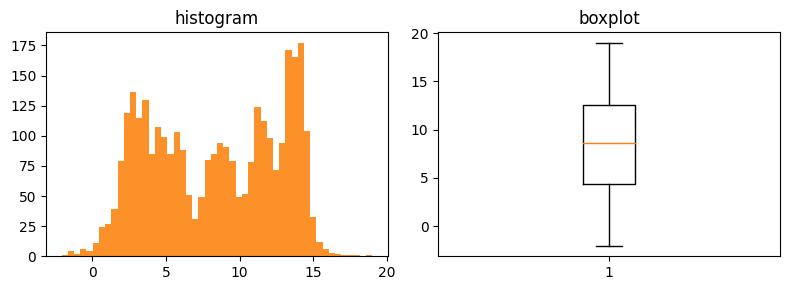

count    3180.000000
mean        8.374731
std         4.381310
min        -2.080000
25%         4.312000
50%         8.610500
75%        12.548250
max        19.021000
Name: temperature, dtype: float64


In [6]:
quick_check(df.temperature)

We know that this column is measured in celsius. We see no real outliers, and temperatures generally range from -2 to 19.

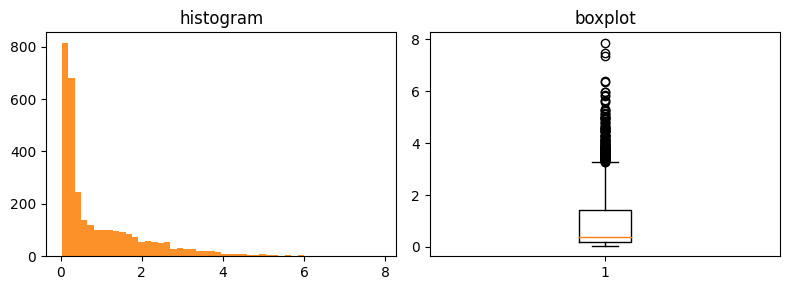

count    3180.000000
mean        0.938468
std         1.096440
min         0.034000
25%         0.186750
50%         0.392000
75%         1.419250
max         7.880000
Name: uncertainty, dtype: float64


In [7]:
quick_check(df.uncertainty)

The given uncertainty measure is the 95% confidence interval around the average and is generally quite low. However, it can take soms high values. We will see later when this tends to happen.

In [8]:
df.date.agg(["min", "max", "count"])

min      1750-01-01 00:00:00
max      2015-12-01 00:00:00
count                   3180
Name: date, dtype: object

Can we see an effect of the month on the temperature? The figure below suggests we can!

Text(0.5, 1.0, '')

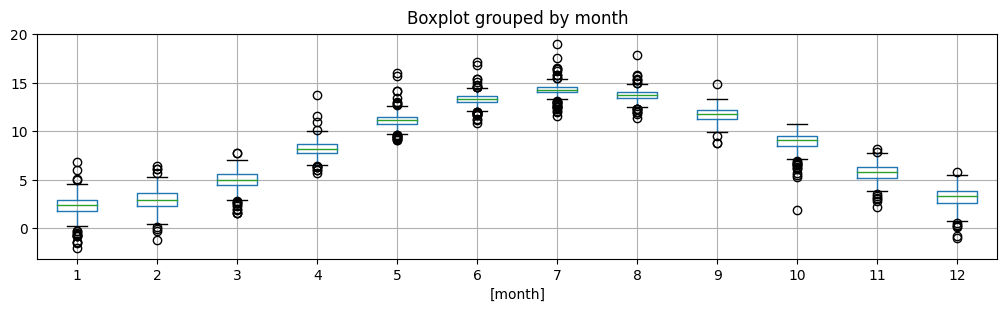

In [9]:
df["month"] = df.date.dt.month
fig, ax = plt.subplots(figsize=(12, 3))
df.boxplot(column=["temperature"], by=["month"], figsize=(10, 3), ax=ax)
ax.set_title(None)

Let's do the same for the year, let's see if we can visualize the effect of global warming.

In [10]:
df["year"] = df.date.dt.year
mean_temp_world = []
mean_temp_world_uncertainty = []

# for year in sorted(df["year"].unique()):
for year in df["year"]:
    mean_temp_world.append(df[df["year"] == year]["temperature"].mean())
    mean_temp_world_uncertainty.append(df[df["year"] == year]["uncertainty"].mean())

    trace0 = go.Scatter(
        x=df["year"],
        y=np.array(mean_temp_world) + np.array(mean_temp_world_uncertainty),
        fill=None,
        mode="lines",
        name="Uncertainty top",
        line=dict(
            color=ae_orange2,
        ),
    )
trace1 = go.Scatter(
    x=df["year"],
    y=np.array(mean_temp_world) - np.array(mean_temp_world_uncertainty),
    fill="tonexty",
    mode="lines",
    name="Uncertainty bot",
    line=dict(
        color=ae_orange2,
    ),
)

trace2 = go.Scatter(
    x=df["year"],
    y=mean_temp_world,
    name="Average Temperature",
    line=dict(
        color=ae_orange,
    ),
)
data = [trace0, trace1, trace2]

layout = go.Layout(
    xaxis=dict(title="year"),
    yaxis=dict(title="Average Temperature, °C"),
    title="Average land temperature in world",
    showlegend=False,
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

The plot above suggests that in fact, global warming is rising rapidly! Also, we can see that the 95% CI shrinks in more recent times. Could you guess why?

In [11]:
# calculate average temperature per year
mean_temp_world = [
    df[df["year"] == year]["temperature"].mean() for year in df.year.unique()
]

# show first 5 years
mean_temp_world[:5]

[8.719363636363637,
 7.9761428571428565,
 5.7798333333333325,
 8.388083333333334,
 8.469333333333333]

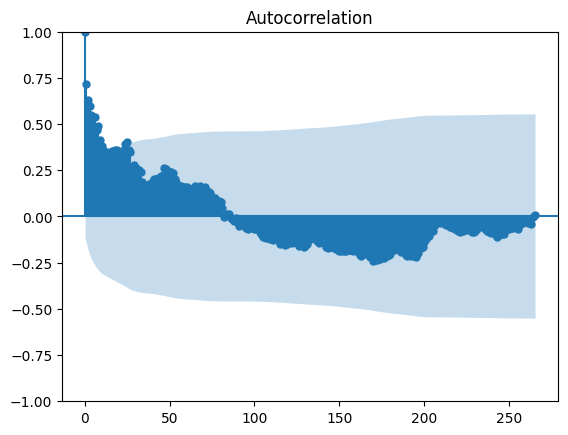

In [12]:
plot_acf(mean_temp_world, lags=len(mean_temp_world) - 1);

Above is a figure of the autocorrelation, between a reference value and another value. It shows the tendency for observations to be related to one another. The first value is 1, which makes sense because a value can fully explain itself. When time goes on, this autocorrelation drops which also makes sense: older data has less predictive power on more recent timepoints. The ACF function even drops below zero: this means that if a past temperature is above the average temperature, a newer temperature is more likely to be below average. You can read more about this here: http://www.pmean.com/09/NegativeAutocorrelation.html

The cone (lightblue) shows a 95% confidence interval, with which you can say something with statistical significance.

In [13]:
ex = pd.concat(
    [
        pd.DataFrame(mean_temp_world).shift(3),
        pd.DataFrame(mean_temp_world).shift(2),
        pd.DataFrame(mean_temp_world).shift(1),
        pd.DataFrame(mean_temp_world),
    ],
    axis=1,
)
# naming the columns
ex.columns = ["t", "t+1", "t+2", "t+3"]

# using corr() function to compute the correlation
result = ex.corr()
result

,t,t+1,t+2,t+3
t,1.000000,0.714860,0.636561,0.641452
t+1,0.714860,1.000000,0.719767,0.643927
t+2,0.636561,0.719767,1.000000,0.725075
t+3,0.641452,0.643927,0.725075,1.000000


This principle is shown in detail for the first three lags. It can be seen that a previous timepoint has a correlation of 0.71 to a next timepoint. When the size of lag increases (t+2, t+3), this autocorrelation decreases. Thus, when creating (linear) models, **having information on the previous timepoint would be very important**. 

### Patterns

Let's look at our time series through another lens. Depending on the type of data and the range of the values, certain types of patterns can appear. In particular, we can look for the following:

* <span style="color:darkorange">**Trend**</span> - this is a general, monotonic increase or decrease in our data.
* <span style="color:darkorange">**Seasonality**</span> - sometimes our values fluctuate in a predictable, calender-bound manner (e.g., with seasons, month, or day of the week).
* <span style="color:darkorange">**Cyclicality**</span> - when you notice a repeating pattern that cannot be attributed to seasonality (i.e., there does not appear to be a straightforward link with the calendar), we call this a cycle.

First, let's check whether our time series is *stationary*. In simple terms, this means that the statistical properties of our time series can be expected to stay constant over time. It also implies that any patterns we find can be expected to stay constant. Stationarity is important, because a number of models expect this condition to be met for the data they attempt to describe. There's a simple test you can use to quickly check for stationarity, called the *Augmented Dickey-Fuller* test. Don't worry about this too much -- just know that a significant result implies that our time series will be easier to model.

In [14]:
from statsmodels.tsa.stattools import adfuller

p_value = adfuller(df.temperature)[1]
f"The p-value for the Augmented Dickey-Fuller test is {round(p_value,3)}, which implies {('stationarity' if p_value < .05 else 'a lack of stationarity')}"

'The p-value for the Augmented Dickey-Fuller test is 0.001, which implies stationarity'

Good! Now let's see if we can detect any patterns. Let's visualize the data again. This is an interactive plot, so feel free to zoom in and observe the patterns for yourself.

In [15]:
fig = px.line(df, x="date", y="temperature")
fig.update_traces(line_color=ae_orange)
fig.update_xaxes(tickformat="%b\n%Y")
fig.show()

It's quite clear that there's a strong seasonal component, as you would expect from a variable such as temperature. We can try and isolate different components as well, using `statsmodels`' time series analysis API. Check it out!

In [16]:
def decompose_signal(time_series: pd.Series, period=12):
    # Perform seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(df.temperature, period=period)

    # Create a figure with 4 subplots
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05)

    # Add the original signal component to the top subplot
    fig.add_trace(
        go.Scatter(x=df.index, y=df.temperature, name="Original"), row=1, col=1
    )

    # Add the seasonal component
    fig.add_trace(
        go.Scatter(
            x=decomposition.seasonal.index, y=decomposition.seasonal, name="Seasonal"
        ),
        row=2,
        col=1,
    )

    # Add the trend component
    fig.add_trace(
        go.Scatter(x=decomposition.trend.index, y=decomposition.trend, name="Trend"),
        row=3,
        col=1,
    )

    # Add the residuals component
    fig.add_trace(
        go.Scatter(
            x=decomposition.resid.index, y=decomposition.resid, name="Residuals"
        ),
        row=4,
        col=1,
    )

    # Customize the figure layout
    fig.update_layout(
        height=800, width=1200, title_text="Decomposition", showlegend=False
    )
    fig.update_traces(line_color=ae_orange, row=1)
    fig.update_xaxes(title_text="")
    fig.update_xaxes(tickformat="%b\n%Y")
    fig.update_yaxes(title_text="Original", row=1)
    fig.update_yaxes(title_text="Seasonal", row=2)
    fig.update_yaxes(title_text="Trend", row=3)
    fig.update_yaxes(title_text="Residuals", row=4)

    fig.show()

In [17]:
df = df.set_index(df.date)
temp = df.temperature
decompose_signal(time_series=temp)

In addition to the seasonal component, we can also better see an *upward trend*. Great! Or not so great. But about what we'd expect, right? As for the residuals, they represent what's left after subtracting trend and seasonality from the original signal. Looks like we don't have to worry about remaining cycles.

We cleaned up our data frame a little bit, so let's store it so we can pick it back up in a new notebook. 

In [18]:
df.to_csv("../../data/cleaned.csv", index=False)

Let's move on to another topic: time series forecasting! [Let's go there now](./2_forecasting.ipynb).